In [1]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import new_interf
#import seaborn as sns

from datetime import datetime, timedelta


No module named 'rtlsdr'


2022-03-16 08:29:43 local time
1647448183.909691 time of observation in bullshit unix
18


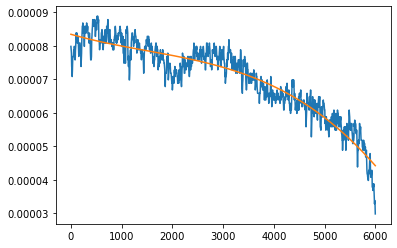

In [2]:
m17_data = pd.read_csv('long_obs_data2.csv')
other_data=pd.read_csv('long_obs_data.csv')

m17_volts = np.array(m17_data['Voltages'])
m17_volts = m17_volts - np.mean(m17_volts) # subtracting the mean (to make it centered at zero)
m17_times = np.array(m17_data['Times'])

def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    return time.strftime('%Y-%m-%d %H:%M:%S')
t= utc_to_local(m17_times[0])
print(t, "local time")

print(m17_times[0], "time of observation in bullshit unix")
m17_times -= m17_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = m17_times[1] - m17_times[0]  # this is the time step between samples
print(len('long_obs_data2.csv'))

m17_volts = m17_volts[m17_times / 60 < 100] #clipping to the first part (good data)
m17_times = m17_times[m17_times / 60 < 100]
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")

#m17_data.drop('Unnamed: 0', axis=1, inplace=True) #drop redundant index columnn to clean dataframe
#other_data.drop('Unnamed: 0', axis=1, inplace=True) #drop redundant index columnn to clean dataframe




# fitting polynomial 
plt.figure()
plt.plot(m17_times, m17_volts)
p= np.polyfit(m17_times, m17_volts, 3)
fit = np.polyval(p, m17_times)
m17_volts-=fit
plt.plot(m17_times, fit)
plt.show()

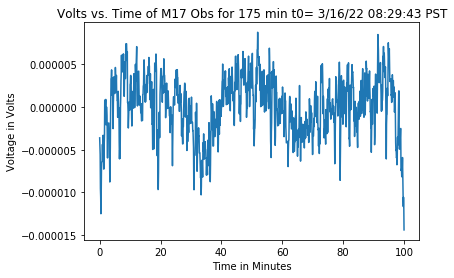

In [3]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of M17 Obs for 175 min t0= 3/16/22 08:29:43 PST")
plt.plot(m17_times/60, m17_volts)

# we can see the frequencies are getting smaller 
# this happens at the horizons 
# frequency changes as the cosine of the angle (highest at zentih and lowest at horizon)

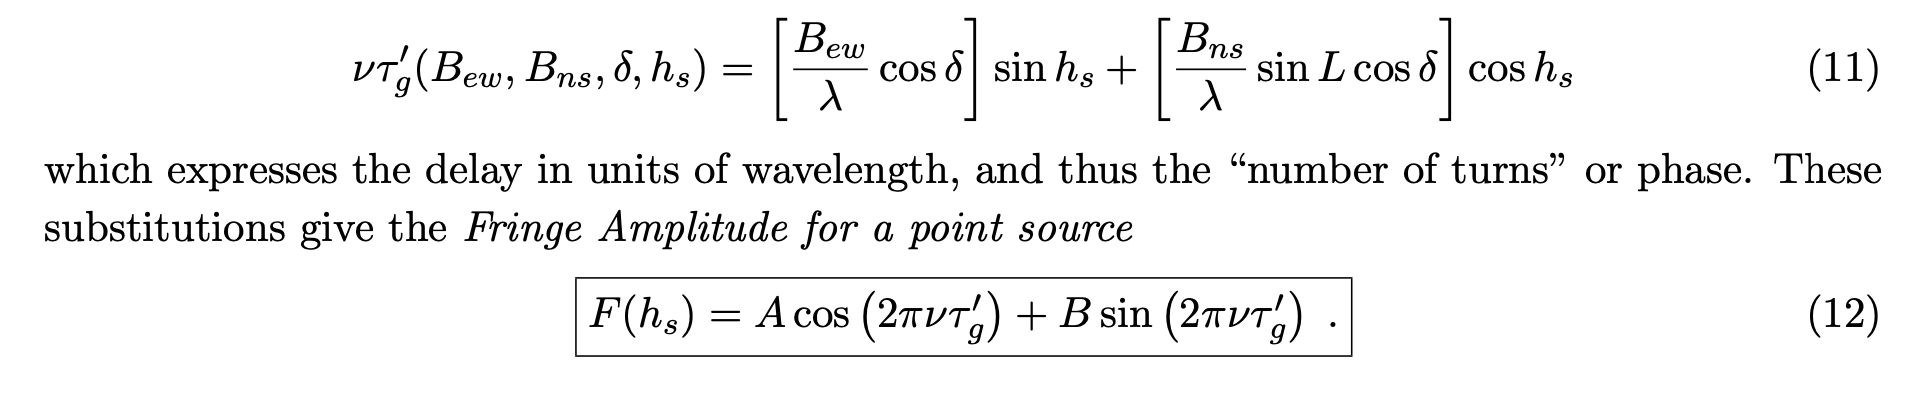

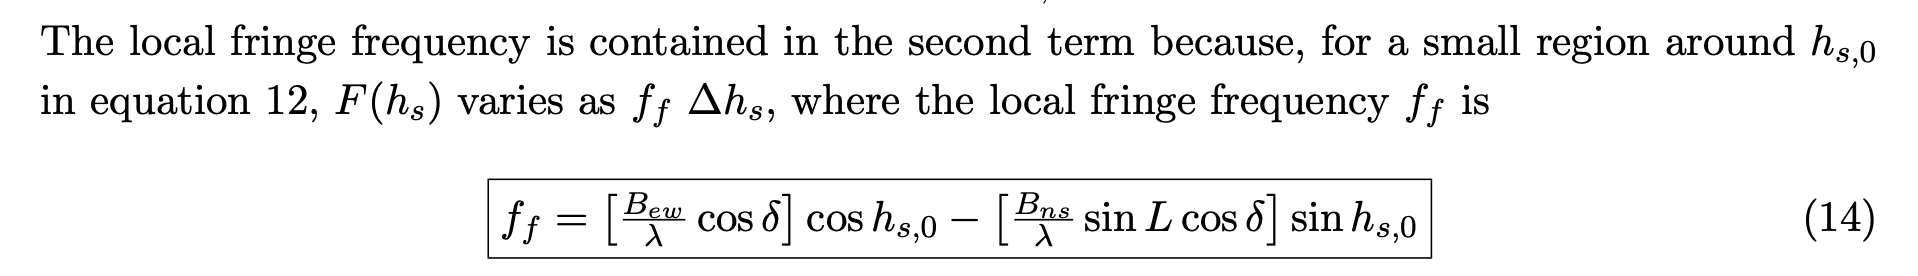


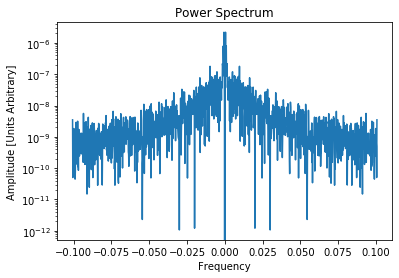

In [16]:
voltage_spectrum = np.fft.fft(m17_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.semilogy(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly

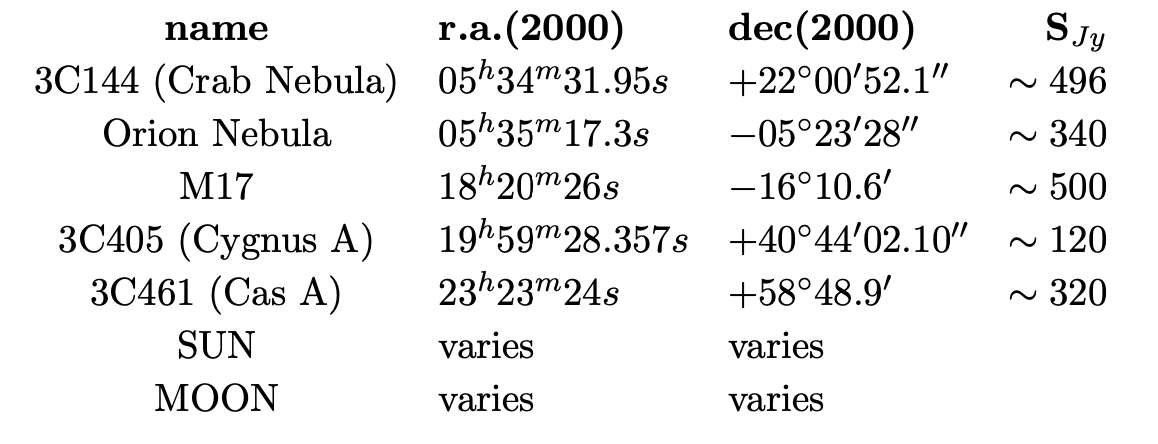


In [17]:
RA_deg= new_interf.time2deg(18, 20, 2)
print(RA_deg, "RA in degrees")
arc_dec= 10.6/60 #converting arc min to degrees 
arc_dec
dec = -16 - arc_dec
print(dec, "Dec in degrees")

precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
RA = np.radians(precess_ra)
Dec = np.radians(precess_dec)
print("RA is", RA, "Dec", Dec )

275.0083333333333 RA in degrees
-16.176666666666666 Dec in degrees
precess_ra is 275.0087775137586 precess_dec is -16.177368391959966
RA is 4.799808639499633 Dec -0.282348342747762


In [18]:
m17_times_JD= ugradio.timing.julian_date(m17_times)
m17_times_LST= ugradio.timing.lst(m17_times_JD)
print(m17_times_LST)
delta = Dec # declination 
B_ew = 20 # baseline east-west in meters
h_s = m17_times_LST - RA # hour angle = LST - RA
h_s = np.where(h_s<0, h_s +2*np.pi, h_s) # adding 2pi to when it is negative angles

wl = .0250  # wavelength in meters

[5.89881367 5.89917549 5.8995401  ... 0.05242331 0.05278792 0.05315254]


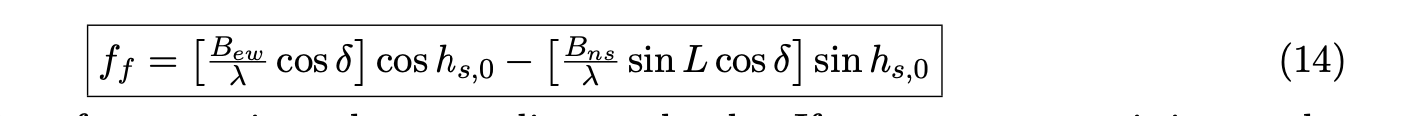


f.min is 0.00030466513645210387
f.max is 0.004041544851791218


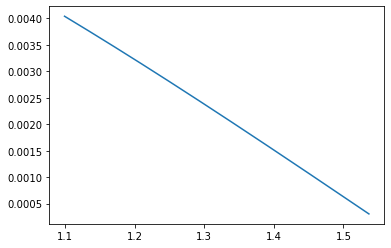

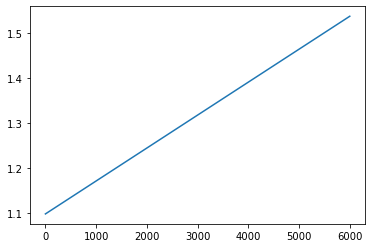

In [21]:
plt.figure()
f = (B_ew/wl * np.cos(delta)) * np.cos(h_s) # we are assuming baseline north-south is 0 
#which is not really true but whatever
f/=24*3600


plt.plot( h_s, f)
plt.figure()
plt.plot(m17_times, h_s)
# this is the spread of the sine wave
print("f.min is", f.min())
print("f.max is", f.max())

# we think this is part of a cosine 
# these are the local fringe freqs

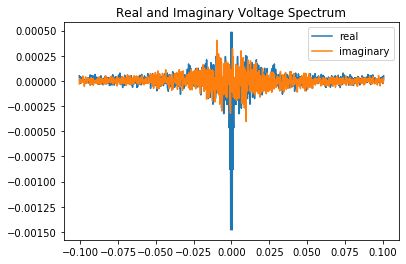

In [20]:
plt.figure()
plt.title("Real and Imaginary Voltage Spectrum")

plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.real), label="real")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.imag), label = "imaginary")# shifting the arrays to read correctly
plt.legend()

In [11]:
m17_spectra = new_interf.f_transform(m17_volts)
new_interf.f_transform??

<IPython.core.display.Javascript object>


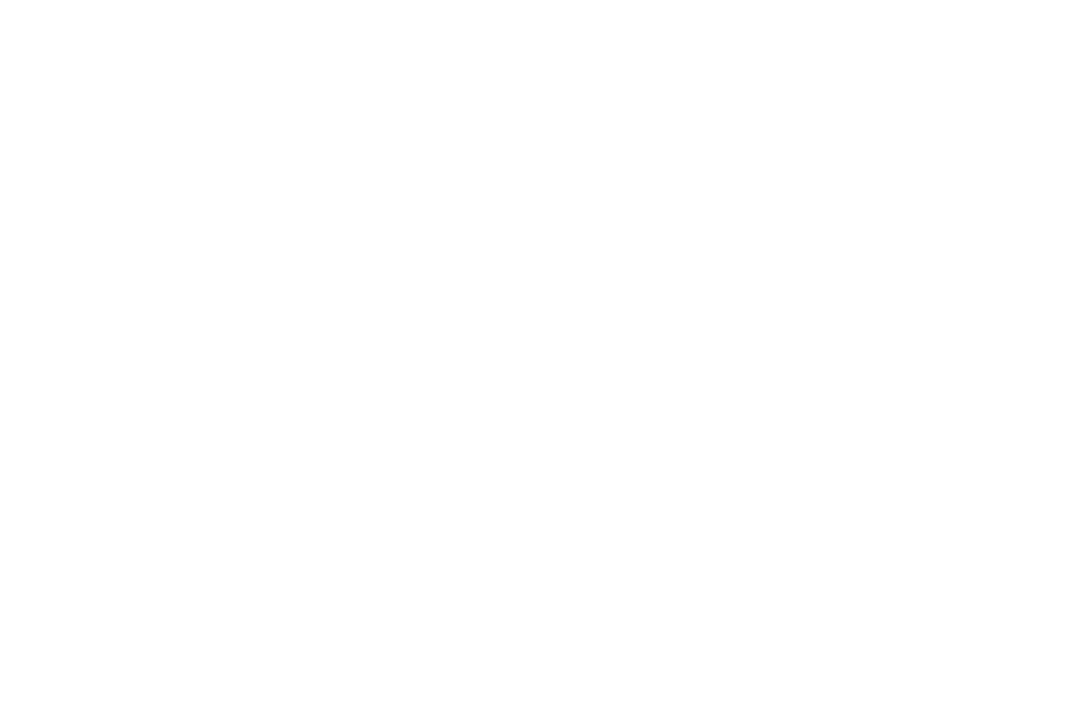

<IPython.core.display.Javascript object>


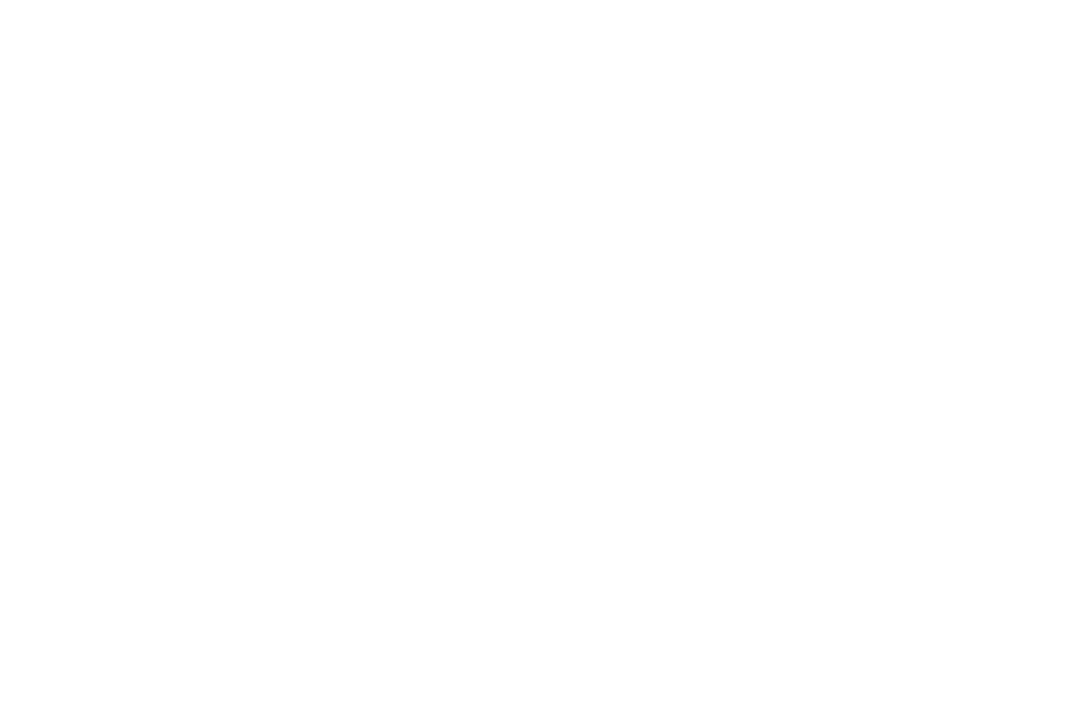

In [12]:
%matplotlib notebook
plt.figure()
plt.grid()
plt.title('Lunar Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [Units Arbitrary]')
plt.plot(m17_spectra[0], m17_spectra[1], label = "M17")
plt.legend()
plt.show()


Alternative formulation of above plots using seaborn; below cell makes aesthetic changes

In [13]:
%matplotlib inline
sns.set_theme(style='ticks', palette='magma')

NameError: name 'sns' is not defined

In [ ]:
sns.lineplot(data=m17_data, y='Voltages', x='Times')
plt.title('V vs t')

In [ ]:
m17_data

In [ ]:
#combine data into one dataframe, with additional column delineating observation type

other_data['Observation']=['obs1']*len(other_data)
m17_data['Observation']=['obs2']*len(m17_data)

df=pd.concat([m17_data, other_data], axis=0)

In [ ]:
v_range = m17_data.Voltages.max()-m17_data.Voltages.min()
#show distribution of voltages
#fig, axes=plt.subplots(figsize=[16, 9], facecolor='#f1f1f1')
dis = sns.displot(data=df, y='Voltages', bins=50, kde=True, col='Observation', palette='magma', alpha=0.4)
dis.fig.suptitle('Distribution of Recorded Voltages')
dis.fig.subplots_adjust(top=0.85)

# Statistical Analysis of dataframe

In [ ]:
m17_data.describe()

In [ ]:
v_range = m17_data.Voltages.max()-m17_data.Voltages.min()
v_range

In [ ]:
m17_cleaned = m17_data.loc[m17_data.Voltages>0.5e-5]
m17_cleaned[r'Voltages ($\mu$V)'] = m17_cleaned['Voltages']/1e-6
dis = sns.displot(data=m17_cleaned, y=r'Voltages ($\mu$V)', bins=25, kde=True, palette='cubehelix', alpha=0.4)
dis.fig.suptitle('Cleaned Data')

In [ ]:
m17_cleaned

In [ ]:
from scipy import special
arr = np.array(range(5000))

In [ ]:
yarr = special.j1(arr[1:])/arr[1:]
plt.plot(arr[1:150], yarr[1:150])

In [ ]:
pspecdf = pd.DataFrame({'pspec':power_spectrum})
pspecdf = pspecdf.loc[pspecdf.pspec<0.0000005]
pspecdf['ifft'] = (np.fft.ifft(np.array(pspecdf.loc[pspecdf.pspec<0.0000005]))**2).real
sns.lineplot(data=pspecdf, x=range(len(pspecdf)), y='ifft')
pspecdf